## Testing Random Forest Model

#### All the needed functions 

In [61]:
#Imports
import statsapi
import datetime 
import pandas as pd
import json
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
#Used in the player stats function
def add_dicts(d1, d2):
    d3 = dict(d1)
    d3.update(d2)
    try:
        for i, j in d1.items():

            for x, y in d2.items():

                if (i == x):

                    d3[i]=(j+y)
    except: pass
    return d3

In [4]:
#Getting start date and end date of a season
def season_start_end(year):
    season_info = statsapi.get("seasons", {"sportId": 1, "season": year})
    season_start = season_info['seasons'][0]['regularSeasonStartDate']
    season_end = season_info['seasons'][0]['regularSeasonEndDate']
    return [season_start, season_end]

In [5]:
#Function to return player stats - hitting, pitching, and fielding

#Inputs are the id, start date and end date and the season year

def player_stats(id,start_date, end_date, year):

    #Getting player stats - separately because the API switches their order when fetched at the same time 
    hitting_stats = statsapi.get("people", {"personIds": id, "hydrate": f"stats(group=[hitting],type=[byDateRange],startDate={start_date},endDate={end_date},season={year})"})
    pitching_stats = statsapi.get("people", {"personIds": id, "hydrate": f"stats(group=[pitching],type=[byDateRange],startDate={start_date},endDate={end_date},season={year})"})
    fielding_stats = statsapi.get("people", {"personIds": id, "hydrate": f"stats(group=[fielding],type=[byDateRange],startDate={start_date},endDate={end_date},season={year})"})

    #dict where I will add all the collected stats
    stat_dict = {}

    #Temporary storage for fielding dicts for all positions
    fielding_list = []

    #List to check if the stats for a fielding position have already been collected - as they are listed more than once
    pos_codes = []

    #Taking last entry of hitting stats, as that is the cumulative for the date range
    try:
        player_hitting_stats = hitting_stats['people'][0]['stats'][0]['splits'][-1]['stat']
        stat_dict['hitting'] = player_hitting_stats
    except: pass
    
    #Taking last entry of pitching stats, as that is the cumulative for the date range
    try:
        player_pitching_stats = pitching_stats['people'][0]['stats'][0]['splits'][-1]['stat']
        stat_dict['pitching'] = player_pitching_stats
    except: pass

    #Summing cumulative fielding stats for each position played (Team changes now accounted for)
    try:
        for i in range(len(fielding_stats['people'][0]['stats'][0]['splits'])):
            if fielding_stats['people'][0]['stats'][0]['splits'][i]['sport']['abbreviation'] == 'All':
                fielding_list.append(fielding_stats['people'][0]['stats'][0]['splits'][i]['stat']) 
                
        all_fielding = {}

        for i in range(len(fielding_list)):
            all_fielding = add_dicts(all_fielding, fielding_list[i])
        stat_dict['fielding'] = all_fielding
        
        
    except:pass
    return stat_dict

In [6]:
#Function that returns the outcomes for each game, as a dict

def season_match_outcomes(season_start, season_end):
    dict_list = []
    for i in statsapi.schedule(start_date=season_start, end_date=season_end):
        match_dict = {}
        try:
            match_dict['game_id'] = i['game_id']
            match_dict['win'] = i['winning_team']
            match_dict['loss'] = i['losing_team']
            dict_list.append(match_dict)
        except: pass
    return dict_list

In [7]:
#Function that calcualtes a team's win % up to a specific date

#Takes the team_id as an input, as well as the start and end date of the period

def team_record(team_id, start_date, end_date):
    results = season_match_outcomes(start_date, end_date)
    wins = 0
    losses = 0
    team_name = statsapi.lookup_team(team_id)[0]['name']
    for i in range(len(results)):
        if team_name == 'Cleveland Guardians':
            if (results[i]['win'] == team_name) or (results[i]['win'] =='Cleveland Indians'):
                wins+=1
            elif (results[i]['loss'] == team_name) or (results[i]['loss'] =='Cleveland Indians'):
                losses+=1
        else:
            if results[i]['win'] == team_name:
                wins+=1
            elif results[i]['loss'] == team_name:
                losses+=1
    return round(wins/(wins+losses),3)

In [8]:
def log_5(home_team_id, away_team_id, start_date, end_date):
    home_per = team_record(home_team_id, start_date, end_date)
    away_per = team_record(away_team_id, start_date, end_date)
    log5 = (home_per - (home_per * away_per))/(home_per + away_per - (2*home_per*away_per))
    return log5

In [9]:
#Function takes two empty dfs with columns created  - see the implementation of the function for the column names
#Takes the home/away team info and their roster lists as inputs, as well as the date of the game
#This is created during the inputting of the two team names, and fed to these functions

def all_hit_stats_df(df_home, df_away, home_info, away_info, h_roster_list, a_roster_list, start_date):

    #End date - date of the game input
    end_date = datetime.datetime.today().strftime('%Y-%m-%d')

    #year is used in the player_stats function, and is the first 4 characters of the date string
    year = 2022

    #Id of home team
    home_id = home_info[0]['id']

    #Id of away team
    away_id = away_info[0]['id']
        
    #Getting start date for rolling 10 day stats - 9 days before the end_date
    rolling_start_date = (datetime.datetime.strptime(end_date, "%Y-%m-%d") + datetime.timedelta(days=-9)).strftime('%Y-%m-%d')

    #List of stats being pulled from API
    hitting_stats = ['hits', 'baseOnBalls', 'atBats', 'hitByPitch','doubles', 'triples', 'homeRuns', 'plateAppearances', 'runs']

    #Calculating log5
    log5 = log_5(home_id, away_id, start_date, end_date)

    #Initializing home stats variables for static hitting stats
    h_hits = 0
    h_baseOnBalls = 0
    h_atBats = 0
    h_hitByPitch = 0
    h_doubles = 0
    h_triples = 0
    h_homeRuns= 0
    h_plateAppearances = 0
    h_runs = 0

    #Initializing home stats variables for rolling hitting stats
    h_r_hits = 0
    h_r_baseOnBalls = 0
    h_r_atBats = 0
    h_r_hitByPitch = 0
    h_r_doubles = 0
    h_r_triples = 0
    h_r_homeRuns= 0
    h_r_plateAppearances = 0

    #Initializing away stats variables for static hitting stats
    a_hits = 0
    a_baseOnBalls = 0
    a_atBats = 0
    a_hitByPitch = 0
    a_doubles = 0
    a_triples = 0
    a_homeRuns= 0
    a_plateAppearances = 0
    a_runs = 0

    #Initializing away stats variables for rolling hitting stats
    a_r_hits = 0
    a_r_baseOnBalls = 0
    a_r_atBats = 0
    a_r_hitByPitch = 0
    a_r_doubles = 0
    a_r_triples = 0
    a_r_homeRuns= 0
    a_r_plateAppearances = 0

    #Getting stats for each player on the home team
    for j in h_roster_list:
        try:
            #Storing all static stats as a list
            stat_list = [player_stats(j, start_date, end_date, year)['hitting'][i] for i in hitting_stats]

            #Adding the home team static stats together for the time period
            h_hits+= stat_list[0]
            h_baseOnBalls+= stat_list[1]
            h_atBats+= stat_list[2]
            h_hitByPitch+= stat_list[3]
            h_doubles+= stat_list[4]
            h_triples+= stat_list[5]
            h_homeRuns+= stat_list[6]
            h_plateAppearances+= stat_list[7]
            h_runs+= stat_list[8]
        except: pass

        try:
            #Storing all rolling stats as a list
            stat_list_10 = [player_stats(j, rolling_start_date, end_date, year)['hitting'][i] for i in hitting_stats]
            
            #Adding the home team rolling stats together for the time period
            h_r_hits+= stat_list_10[0]
            h_r_baseOnBalls+= stat_list_10[1]
            h_r_atBats+= stat_list_10[2]
            h_r_hitByPitch+= stat_list_10[3]
            h_r_doubles+= stat_list_10[4]
            h_r_triples+= stat_list_10[5]
            h_r_homeRuns+= stat_list_10[6]
            h_r_plateAppearances+= stat_list_10[7]
        except: pass

    #Getting stats for each player on the away team
    for j in a_roster_list:
        try:
            #Storing all static stats as a list
            stat_list = [player_stats(j, start_date, end_date, year)['hitting'][i] for i in hitting_stats]

            #Adding the away team stats together for the time period
            a_hits+= stat_list[0]
            a_baseOnBalls+= stat_list[1]
            a_atBats+= stat_list[2]
            a_hitByPitch+= stat_list[3]
            a_doubles+= stat_list[4]
            a_triples+= stat_list[5]
            a_homeRuns+= stat_list[6]
            a_plateAppearances+= stat_list[7]
            a_runs+= stat_list[8]
        except: pass
        
        try:
            #Storing all rolling stats as a list
            stat_list_10 = [player_stats(j, rolling_start_date, end_date, year)['hitting'][i] for i in hitting_stats]

            #Adding the away team rolling stats together for the time period
            a_r_hits+= stat_list_10[0]
            a_r_baseOnBalls+= stat_list_10[1]
            a_r_atBats+= stat_list_10[2]
            a_r_hitByPitch+= stat_list_10[3]
            a_r_doubles+= stat_list_10[4]
            a_r_triples+= stat_list_10[5]
            a_r_homeRuns+= stat_list_10[6]
            a_r_plateAppearances+= stat_list_10[7]
        except: pass


    #appending stats to their respective dfs
    df_home.loc[len(df_home)] = [round(h_hits/h_atBats,3),round((h_hits+h_baseOnBalls+h_hitByPitch)/h_plateAppearances,3),round((h_hits+h_doubles+h_triples*2+h_homeRuns*3)/h_atBats,3),round((h_r_hits+h_r_baseOnBalls+h_r_hitByPitch)/h_r_plateAppearances,3),round((h_r_hits+h_r_doubles+h_r_triples*2+h_r_homeRuns*3)/h_r_atBats,3), log5, h_runs,0]
    df_away.loc[len(df_away)] = [round(a_hits/a_atBats,3),round((a_hits+a_baseOnBalls+a_hitByPitch)/a_plateAppearances,3),round((a_hits+a_doubles+a_triples*2+a_homeRuns*3)/a_atBats,3),round((a_r_hits+a_r_baseOnBalls+a_r_hitByPitch)/a_r_plateAppearances,3),round((a_r_hits+a_r_doubles+a_r_triples*2+a_r_homeRuns*3)/a_r_atBats,3), 0,0,(a_runs*-1)]
    #Returning the difference of home and away team stats
    return df_home.subtract(df_away, fill_value =0)



In [10]:
#Function takes two empty dfs with columns created  - see the implementation of the function for the column names
#Takes the home/away team info and their roster lists as inputs
#This is created during the inputting of the two team names, and fed to these functions

def all_pitch_stats_df(df_home, df_away, home_info, away_info, h_roster_list, a_roster_list, start_date):

    #End date - date of the game input
    end_date = datetime.datetime.today().strftime('%Y-%m-%d')

    #year is used in the player_stats function, and is the first 4 characters of the date string
    year = 2022

    #Start date for the 10 day rolling whip
    rolling_start_date = (datetime.datetime.strptime(end_date, "%Y-%m-%d") + datetime.timedelta(days=-9)).strftime('%Y-%m-%d')

    #Id of home team
    home_id = home_info[0]['id']

    #Id of away team
    away_id = away_info[0]['id']

    #List of pitching stats used in calculations
    pitching_stats = ['earnedRuns', 'inningsPitched', 'baseOnBalls', 'hits']

    #List of stats for rolling whip average
    whip_stats_list = ['hits', 'inningsPitched', 'baseOnBalls']

    #Try/except since sometimes a starting is pitching for the first time and has no information stored here.
    try:
        #Getting home starting pitcher
        h_sp = statsapi.lookup_player(statsapi.schedule(datetime.datetime.today().strftime('%Y-%m-%d'), team = home_info[0]['id'])[0]['home_probable_pitcher'])[0]['id']
    except: h_sp = ''
    
    try:
        #Getting away starting pitcher
        a_sp = statsapi.lookup_player(statsapi.schedule(datetime.datetime.today().strftime('%Y-%m-%d'), team = home_info[0]['id'])[0]['away_probable_pitcher'])[0]['id']
    except: a_sp = ''

    #Initializing home team static stats variables
    #h_runs is for bullpen earned runs allowed
    h_runs = 0
    h_inningsPitched = 0
    h_walks = 0
    h_hits = 0
    #This is runs allowed for all players (earned and unearned)
    h_runs_allowed = 0

    #Initializing away team static stats variables
    a_runs = 0
    a_inningsPitched = 0
    a_walks = 0
    a_hits = 0
    #This is runs allowed for all players (earned and unearned)
    a_runs_allowed = 0

    #Initializing home team rolling stats variables
    h_r_hits = 0
    h_r_inningsPitched = 0
    h_r_walks = 0

    #Initializing away team rolling stats variables
    a_r_hits = 0
    a_r_inningsPitched = 0
    a_r_walks = 0

#Checking if starting pitcher is known yet
    if h_sp == '' or a_sp == '':
        h_sp_runs = 1
        h_sp_inningsPitched = 1
        h_sp_walks = 1
        h_sp_hits = 1
        a_sp_runs = 1
        a_sp_inningsPitched = 1
        a_sp_walks = 1
        a_sp_hits = 1
    else:
        #Getting stats for the starting pitcher
        h_stat_list = [player_stats(h_sp, start_date, end_date, year)['pitching'][i] for i in pitching_stats]

        #Changing string to float
        h_stat_list[1] = float(h_stat_list[1])

        #Checking if innings pitched ends in a 0.1 or 0.2 and changing this to the proper decimal for 1/3 or 2/3.
        if round(h_stat_list[1] - int(h_stat_list[1]),1) == 0.2:
            h_stat_list[1] = int(h_stat_list[1]) + 0.666
        elif round(h_stat_list[1] - int(h_stat_list[1]),1) == 0.1:
            h_stat_list[1] = int(h_stat_list[1]) + 0.333

        #Summing stats for starting pitcher
        h_sp_runs = h_stat_list[0]
        h_sp_inningsPitched = h_stat_list[1]
        h_sp_walks = h_stat_list[2]
        h_sp_hits = h_stat_list[3]

        a_stat_list = [player_stats(a_sp, start_date, end_date, year)['pitching'][i] for i in pitching_stats]

        #Changing string to float
        a_stat_list[1] = float(a_stat_list[1])

        #Checking if innings pitched ends in a 0.1 or 0.2 and changing this to the proper decimal for 1/3 or 2/3.
        if round(a_stat_list[1] - int(a_stat_list[1]),1) == 0.2:
            a_stat_list[1] = int(a_stat_list[1]) + 0.666
        elif round(a_stat_list[1] - int(a_stat_list[1]),1) == 0.1:
            a_stat_list[1] = int(a_stat_list[1]) + 0.333

        a_sp_runs = a_stat_list[0]
        a_sp_inningsPitched = a_stat_list[1]
        a_sp_walks = a_stat_list[2]
        a_sp_hits = a_stat_list[3]

    #Getting stats of all players in the bullpen for the home team this game
    for j in h_roster_list:
        try:
            if player_stats(j, start_date, end_date, year)['pitching']['gamesStarted'] <= 8: 
                #Getting all home team stats
                stat_list = [player_stats(j, start_date, end_date, year)['pitching'][i] for i in pitching_stats]
                #Changing string to float
                stat_list[1] = float(stat_list[1])

                #Checking if innings pitched ends in a 0.1 or 0.2 and changing this to the proper decimal for 1/3 or 2/3.
                if round(stat_list[1] - int(stat_list[1]),1) == 0.2:
                    stat_list[1] = int(stat_list[1]) + 0.666
                elif round(stat_list[1] - int(stat_list[1]),1) == 0.1:
                    stat_list[1] = int(stat_list[1]) + 0.333

                #Summing stats for each team (players) for each game
                h_runs+= stat_list[0]
                h_inningsPitched+= stat_list[1]
                h_walks+= stat_list[2]
                h_hits+= stat_list[3]
        except: pass
    for j in h_roster_list:
        try:
            #Getting all home team stats for 10 day whip
            stat_list_10 = [player_stats(j, rolling_start_date, end_date, year)['pitching'][i] for i in whip_stats_list]

            #Getting runs allowed  for all possible pitchers
            h_runs_allowed+= player_stats(j, start_date, end_date, year)['pitching']['runs'] 

            #Changing string to float
            stat_list_10[1] = float(stat_list_10[1])

            #Checking if innings pitched ends in a 0.1 or 0.2 and changing this to the proper decimal for 1/3 or 2/3.
            if round(stat_list_10[1] - int(stat_list_10[1]),1) == 0.2:
                stat_list_10[1] = int(stat_list_10[1]) + 0.666
            elif round(stat_list_10[1] - int(stat_list_10[1]),1) == 0.1:
                stat_list_10[1] = int(stat_list_10[1]) + 0.333

            #Summing stats for each team (players) for each game
            h_r_hits+= stat_list_10[0]
            h_r_inningsPitched+= stat_list_10[1]
            h_r_walks+= stat_list_10[2]

        except: pass

    for j in a_roster_list:
        try:
            if player_stats(j, start_date, end_date, year)['pitching']['gamesStarted'] <= 8: 
                #Getting all away team stats
                stat_list = [player_stats(j, start_date, end_date, year)['pitching'][i] for i in pitching_stats]
                #Changing string to float
                stat_list[1] = float(stat_list[1])

                #Checking if innings pitched ends in a 0.1 or 0.2 and changing this to the proper decimal for 1/3 or 2/3.
                if round(stat_list[1] - int(stat_list[1]),1) == 0.2:
                    stat_list[1] = int(stat_list[1]) + 0.666
                elif round(stat_list[1] - int(stat_list[1]),1) == 0.1:
                    stat_list[1] = int(stat_list[1]) + 0.333

                a_runs+= stat_list[0]
                a_inningsPitched+= stat_list[1]
                a_walks+= stat_list[2]
                a_hits+= stat_list[3]
        except: pass
    for j in a_roster_list:
        try:
            #Getting all away team stats for 10 day whip
            stat_list_10 = [player_stats(j, rolling_start_date, end_date, year)['pitching'][i] for i in whip_stats_list]

            #Getting runs allowed  for all possible pitchers
            a_runs_allowed+= player_stats(j, start_date, end_date, year)['pitching']['runs'] 

            #Changing string to float
            stat_list_10[1] = float(stat_list_10[1])

            #Checking if innings pitched ends in a 0.1 or 0.2 and changing this to the proper decimal for 1/3 or 2/3.
            if round(stat_list_10[1] - int(stat_list_10[1]),1) == 0.2:
                stat_list_10[1] = int(stat_list_10[1]) + 0.666
            elif round(stat_list_10[1] - int(stat_list_10[1]),1) == 0.1:
                stat_list_10[1] = int(stat_list_10[1]) + 0.333

            #Summing stats for each team (players) for each game
            a_r_hits+= stat_list_10[0]
            a_r_inningsPitched+= stat_list_10[1]
            a_r_walks+= stat_list_10[2]
            
        except: pass
    #appending stats to the df
    df_home.loc[len(df_home)] = [round(h_sp_runs*9/h_sp_inningsPitched,3),round((h_sp_hits+h_sp_walks)/h_sp_inningsPitched,3),round(h_runs*9/h_inningsPitched,3),round((h_hits+h_walks)/h_inningsPitched,3),round((h_r_hits+h_r_walks)/h_r_inningsPitched,3),h_runs_allowed,0]
    df_away.loc[len(df_away)] = [round(a_sp_runs*9/a_sp_inningsPitched,3),round((a_sp_hits+a_sp_walks)/a_sp_inningsPitched,3),round(a_runs*9/a_inningsPitched,3),round((a_hits+a_walks)/a_inningsPitched,3),round((a_r_hits+a_r_walks)/a_r_inningsPitched,3),0,(a_runs_allowed*-1)]
  
    return df_home.subtract(df_away, fill_value =0)


In [11]:
#Function that compiles all stats for home team - away team

#Inputs are game id and 4 total empty dfs for home and away hitting and pitching

def all_team_stats(df_h_h, df_a_h, df_h_p, df_a_p,home_info, away_info, h_roster_list, a_roster_list, start_date):

    #Hitting stats df
    df_h = all_hit_stats_df(df_h_h, df_a_h,home_info, away_info, h_roster_list, a_roster_list, start_date)
    
    #Pitching stats df
    df_p = all_pitch_stats_df(df_h_p, df_a_p,home_info, away_info, h_roster_list, a_roster_list, start_date)

    #Calculating PE_diff for home and away teams
    PE_home = (df_h['h_runs']**(1.83))/((df_h['h_runs']**(1.83)+ df_p['h_runs_allowed']**(1.83)))
    PE_away = (df_h['a_runs']**(1.83))/((df_h['a_runs']**(1.83)+ df_p['a_runs_allowed']**(1.83)))
    PE_diff = PE_home - PE_away

    #Dropping runs and runs allowed columns
    df_h.drop(columns = ['h_runs', 'a_runs'], axis=1, inplace=True)
    df_p.drop(columns = ['h_runs_allowed', 'a_runs_allowed'], axis=1, inplace=True)

    #Creating PE column
    df_h['PE'] = PE_diff

    #define list of DataFrames
    dfs = [df_h, df_p]

    #merge all DataFrames into one
    final_df = reduce(lambda left,right: pd.merge(left,right,left_index = True, right_index=True, how='outer'), dfs)
    return final_df

In [12]:
#Creating the empty dfs to be populated by all_team_stats

#Name of columns
team_hit_stats = ['avg', 'obp', 'slug', 'obp_10', 'slug_10', 'log_5', 'h_runs', 'a_runs']

#dfs
df_h_h = pd.DataFrame(columns = team_hit_stats)
df_a_h = pd.DataFrame(columns = team_hit_stats)
df_h_p = pd.DataFrame(columns = ['era_sp', 'whip_sp', 'era_bp', 'whip_bp', 'whip_10', 'h_runs_allowed', 'a_runs_allowed'])
df_a_p = pd.DataFrame(columns = ['era_sp', 'whip_sp', 'era_bp', 'whip_bp', 'whip_10', 'h_runs_allowed', 'a_runs_allowed'])

In [13]:
def test_run():
    #Inputting both teams in the matchup
    home_team = input('Enter the name of the home team')
    away_team = input('Enter the name of the away team')

    #Getting basic team info
    home_info = statsapi.lookup_team(home_team)
    away_info = statsapi.lookup_team(away_team)

    #Getting dictionary of team roster from API
    h_roster_dict = statsapi.get("team_roster", {"teamId": home_info[0]['id']})
    a_roster_dict = statsapi.get("team_roster", {"teamId": away_info[0]['id']})

    #Storing player_ids as a list
    h_roster_list = [h_roster_dict['roster'][i]['person']['id'] for i in range(len(h_roster_dict['roster']))]
    a_roster_list = [a_roster_dict['roster'][i]['person']['id'] for i in range(len(a_roster_dict['roster']))]

    #Start of the 2022 season
    start_date = season_start_end(2022)[0]

    #Creating the empty dfs to be populated by all_team_stats

    #Name of columns
    team_hit_stats = ['avg', 'obp', 'slug', 'obp_10', 'slug_10', 'log_5', 'h_runs', 'a_runs']
    team_pitch_stats = ['era_sp', 'whip_sp', 'era_bp', 'whip_bp', 'whip_10', 'h_runs_allowed', 'a_runs_allowed']

    #dfs
    df_h_h = pd.DataFrame(columns = team_hit_stats)
    df_a_h = pd.DataFrame(columns = team_hit_stats)
    df_h_p = pd.DataFrame(columns = team_pitch_stats)
    df_a_p = pd.DataFrame(columns = team_pitch_stats)

    #Executing all_team_stats function
    df = all_team_stats(df_h_h,df_a_h,df_h_p,df_a_p,home_info, away_info, h_roster_list, a_roster_list, start_date)
    return df

### Testing Model

In [88]:
#Building df
df1 = pd.read_csv('Games_1_100.csv')
df2 = pd.read_csv('Games_101_200.csv')
df3 = pd.read_csv('Games_201_300.csv')
df4 = pd.read_csv('Games_301_350.csv')
df5 = pd.read_csv('Games_351_450.csv')
df6 = pd.read_csv('Games_451_550.csv')
df7 = pd.read_csv('Games_551_650.csv')
df8 = pd.read_csv('Games_651_750.csv')
df9 = pd.read_csv('Games_751_850.csv')
df10 = pd.read_csv('Games_851_950.csv')

In [50]:
#Dropping unnamed column - commenting out as it is now done
#df3.drop(columns = 'Unnamed: 0', inplace = True)
#df3.to_csv('Games_201_300.csv', index= False)
#df10.drop(columns = 'Unnamed: 0', inplace = True)
#df10.to_csv('Games_851_950.csv', index= False)

In [92]:
#Creating one df for all the data, dropping game_id
frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
result = pd.concat(frames)
df = result.copy()
df.drop(columns = 'game_id', inplace = True)

0.6190476190476191
[[40 45]
 [27 77]]
              precision    recall  f1-score   support

        loss       0.60      0.47      0.53        85
         win       0.63      0.74      0.68       104

    accuracy                           0.62       189
   macro avg       0.61      0.61      0.60       189
weighted avg       0.62      0.62      0.61       189



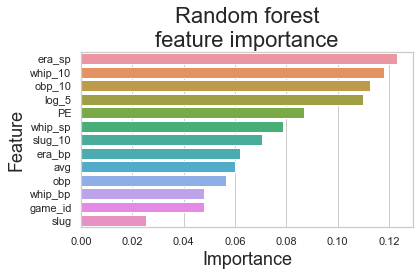

In [93]:
#Training Model on first 100 games to start
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


#Defining X and y variables
X = df.drop(['home_win'], axis=1)
y = df['home_win']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

n_estimators = 10
max_depth = 6
max_features = 3 

#Script for Logistical Regression
global model
model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features, random_state=10)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
target_names=['loss', 'win']

# Calculate feature importance in random forest
importances = model.feature_importances_
labels = df.columns
feature_df = pd.DataFrame(list(zip(labels, importances)), columns = ["feature","importance"])
feature_df = feature_df.sort_values(by='importance', ascending=False,)

# image formatting
axis_fs = 18 #fontsize
title_fs = 22 #fontsize
sns.set(style="whitegrid")

ax = sns.barplot(x="importance", y="feature", data=feature_df)
ax.set_xlabel('Importance',fontsize = axis_fs) 
ax.set_ylabel('Feature', fontsize = axis_fs)#ylabel
ax.set_title('Random forest\nfeature importance', fontsize = title_fs)

plt.tight_layout()
plt.savefig("feature_importance.png",dpi=120)


print(accuracy_score(y_test, y_pred))
# Report training set score
train_score = model.score(x_train, y_train) * 100
# Report test set score
test_score = model.score(x_test, y_test) * 100
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred,target_names=target_names))

In [56]:
def model_run():
    #Inputting both teams in the matchup
    home_team = input('Enter the name of the home team')
    away_team = input('Enter the name of the away team')

    #Getting basic team info
    home_info = statsapi.lookup_team(home_team)
    away_info = statsapi.lookup_team(away_team)

    #Getting dictionary of team roster from API
    h_roster_dict = statsapi.get("team_roster", {"teamId": home_info[0]['id']})
    a_roster_dict = statsapi.get("team_roster", {"teamId": away_info[0]['id']})

    #Storing player_ids as a list
    h_roster_list = [h_roster_dict['roster'][i]['person']['id'] for i in range(len(h_roster_dict['roster']))]
    a_roster_list = [a_roster_dict['roster'][i]['person']['id'] for i in range(len(a_roster_dict['roster']))]

    #Start of the 2022 season
    start_date = season_start_end(2022)[0]

    #Creating the empty dfs to be populated by all_team_stats

    #Name of columns
    team_hit_stats = ['avg', 'obp', 'slug', 'obp_10', 'slug_10', 'log_5', 'h_runs', 'a_runs']
    team_pitch_stats = ['era_sp', 'whip_sp', 'era_bp', 'whip_bp', 'whip_10', 'h_runs_allowed', 'a_runs_allowed']

    #dfs
    df_h_h = pd.DataFrame(columns = team_hit_stats)
    df_a_h = pd.DataFrame(columns = team_hit_stats)
    df_h_p = pd.DataFrame(columns = team_pitch_stats)
    df_a_p = pd.DataFrame(columns = team_pitch_stats)

    #Executing all_team_stats function
    df = all_team_stats(df_h_h,df_a_h,df_h_p,df_a_p,home_info, away_info, h_roster_list, a_roster_list, start_date)

    #Data to use in prediction
    Xnew = df

    # make a prediction
    ynew = model.predict(Xnew)

    #Printing data being used (checking)
    print('Data Used:')
    print(Xnew)
    print('')
    print('Final Results:')
    #Print winning team
    if ynew[0] == 1:
        print(f'{home_team} win')
    elif ynew[0] == 0:
        print(f'{away_team} win')

In [42]:
model_run()

     avg    obp   slug  obp_10  slug_10     log_5        PE  era_sp  whip_sp  \
0  0.019  0.017  0.045  -0.032   -0.006  0.696384  0.313761  -1.706   -0.177   

   era_bp  whip_bp  whip_10  
0  -0.384     -0.2   -0.211  
dodgers win


## Looking at different models